<a href="https://colab.research.google.com/github/aimbsg/EVA4_S6/blob/master/1_EVA4S6_No_L1_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target - Along with batch normalization dropout(0.05) is added IN ALL LAYERS EXCEPT LAST LAYER and image augmentation is used. Global Average Pooling is introduced and expecting to hit 99.4% consistently.

Result - Best accuracy : 99.06%(train) 99.46%(test) ; Params : 8,936

Analysis - No overfit in the model is observed. Train accuracy is less than test accuracy complementing the use of regularization and augmentation strategies. Final few epochs are above 99.4% consistently.

Regularization - No L1 and L2

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [0]:
# # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# # Let's visualize some of the images
# %matplotlib inline
# import matplotlib.pyplot as plt

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [0]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 4
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 4
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             720
             ReLU-12            [-1, 8, 10, 10]               0
      BatchNorm2d-13            [-1, 8, 10, 10]              16
          Dropout-14            [-

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1365603357553482 Batch_id=468 Accuracy=89.59: 100%|██████████| 469/469 [00:18<00:00, 25.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0917, Accuracy: 9733/10000 (97.33%)

EPOCH: 1


Loss=0.025388116016983986 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:18<00:00, 25.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Accuracy: 9811/10000 (98.11%)

EPOCH: 2


Loss=0.1276828795671463 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9889/10000 (98.89%)

EPOCH: 3


Loss=0.027258912101387978 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.043486759066581726 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.028931384906172752 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9926/10000 (99.26%)

EPOCH: 6


Loss=0.010442554950714111 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:18<00:00, 24.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.11714527755975723 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9900/10000 (99.00%)

EPOCH: 8


Loss=0.02963145077228546 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:19<00:00, 24.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.08270617574453354 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:18<00:00, 24.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Loss=0.04395914077758789 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:18<00:00, 24.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9905/10000 (99.05%)

EPOCH: 11


Loss=0.012310047633945942 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:19<00:00, 24.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=0.05835026875138283 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.04516695439815521 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:18<00:00, 24.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.024830644950270653 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:19<00:00, 24.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.05835790932178497 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.040301937609910965 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:19<00:00, 24.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9928/10000 (99.28%)

EPOCH: 17


Loss=0.1018298789858818 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:18<00:00, 25.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.055996235460042953 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:18<00:00, 24.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


Loss=0.03934966027736664 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:18<00:00, 25.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9942/10000 (99.42%)

EPOCH: 20


Loss=0.02025519870221615 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:18<00:00, 25.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)

EPOCH: 21


Loss=0.0331861674785614 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:18<00:00, 25.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 22


Loss=0.017129579558968544 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:21<00:00, 21.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Loss=0.007416144013404846 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:19<00:00, 24.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9929/10000 (99.29%)

EPOCH: 24


Loss=0.04129084572196007 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:19<00:00, 28.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 25


Loss=0.05154763534665108 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:19<00:00, 24.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9946/10000 (99.46%)

EPOCH: 26


Loss=0.004814118146896362 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:19<00:00, 23.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9936/10000 (99.36%)

EPOCH: 27


Loss=0.012369860894978046 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:19<00:00, 23.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.36%)

EPOCH: 28


Loss=0.04537775740027428 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:19<00:00, 28.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 29


Loss=0.053430747240781784 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:19<00:00, 24.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9931/10000 (99.31%)

EPOCH: 30


Loss=0.09096118062734604 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 31


Loss=0.023201966658234596 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.33%)

EPOCH: 32


Loss=0.019061746075749397 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9932/10000 (99.32%)

EPOCH: 33


Loss=0.03211163356900215 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9938/10000 (99.38%)

EPOCH: 34


Loss=0.005529513116925955 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:19<00:00, 30.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9939/10000 (99.39%)

EPOCH: 35


Loss=0.006404101848602295 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:19<00:00, 24.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9942/10000 (99.42%)

EPOCH: 36


Loss=0.032776255160570145 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:19<00:00, 24.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9938/10000 (99.38%)

EPOCH: 37


Loss=0.02655615471303463 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 24.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9943/10000 (99.43%)

EPOCH: 38


Loss=0.01676737703382969 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:19<00:00, 24.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.41%)

EPOCH: 39


Loss=0.02708599902689457 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:19<00:00, 24.29it/s]



Test set: Average loss: 0.0177, Accuracy: 9939/10000 (99.39%)



Text(0.5, 1.0, 'Test Accuracy')

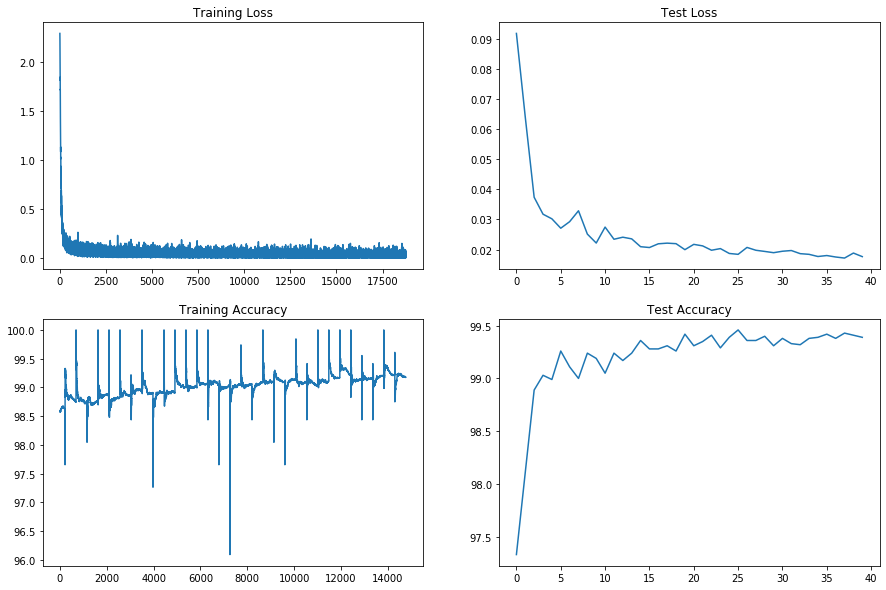

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
import os
os.chdir('/content/gdrive/My Drive/EVA4S6_Train_Test_Accu_Loss')
os.getcwd()

'/content/gdrive/My Drive/EVA4S6_Train_Test_Accu_Loss'

In [0]:
torch.save(test_acc,'no_L1_no_L2_test_acc.pt')
torch.save(test_losses,'no_L1_no_L2_test_loss.pt')